In [80]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path

from aimlsse_api.data.metar import *

In [81]:
target_state = 'California'

In [115]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [82]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
dataset_dir = os.path.join(data_dir, 'dataset')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir, dataset_dir]:
    os.makedirs(dir, exist_ok=True)

In [83]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [84]:
sentinel_products_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0)
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 3569 sentinel products


In [85]:
sentinel_products_metadata.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid'],
      dtype='object')

In [86]:
station_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'station_metadata.csv'), index_col='id')
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 5656 stations


In [87]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,USA,United States of America,North America,0.0
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,USA,United States of America,North America,0.0
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,USA,United States of America,North America,0.0
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,USA,United States of America,North America,0.0
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,USA,United States of America,North America,0.0
...,...,...,...,...,...,...,...,...,...,...,...
53150,POINT (-119.82000 37.75000),53150,NaN,USCRN,37.75000,-119.82000,6620.0000,USA,United States of America,North America,0.0
LOX,POINT (-119.13000 34.20000),LOX,NaN,WFO,34.20000,-119.13000,19.0000,USA,United States of America,North America,0.0
STO,POINT (-121.38000 38.60000),STO,NaN,WFO,38.60000,-121.38000,21.0000,USA,United States of America,North America,0.0


In [88]:
all_metars = pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table')
all_metars.drop_duplicates(subset=['station', 'datetime'])
all_metars['datetime'] = pd.to_datetime(all_metars['datetime'], unit='ms', utc=True)
print(all_metars.shape[0])

8211


In [89]:
pd.set_option('display.max_colwidth', None)
all_metars['sky_conditions [M]']

0                                                                  [{'cloud': None, 'cover': 'SCT', 'height': 1127.7599639117}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
1       [{'cloud': None, 'cover': 'FEW', 'height': 182.8799941478}, {'cloud': None, 'cover': 'SCT', 'height': 1676.3999463552}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
2                                                                    [{'cloud': None, 'cover': 'SCT', 'height': 274.3199912218}, {'cloud': None, 'cover': 'OVC', 'height': 487.6799843942}]
3                                                                                                                              [{'cloud': None, 'cover': 'OVC', 'height': 1402.0799551334}]
4                                                                                                                              [{'cloud': None, 'cover': 'OVC', 'height': 1341.1199570842}]
                                                            

In [90]:
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], all_metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print([str(prop) for prop in metar_properties])

['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']


In [91]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

{'cloud': None, 'cover': 'OVC', 'height': 792.4799746406}


In [92]:
all_metars = MetarPandas.format_dataframe(all_metars, metar_properties)

In [93]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

DataSkyConditions(cover='OVC', height=792.4799746406, cloud=None)


In [94]:
metars_per_product = all_metars.groupby(['product_id'])
print(f'Found METARs for {len(metars_per_product.groups)} products')

Found METARs for 1834 products


In [96]:
product_files = os.listdir(features_dir)
print(f'Found {len(product_files)} products')

Found 1590 products


In [97]:
for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files))):
    filepath = os.path.join(features_dir, file)
    with ZipFile(filepath) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(filepath)
products = os.listdir(features_dir)

0it [00:00, ?it/s]


Text(0.5, 0, 'cloud cover %')

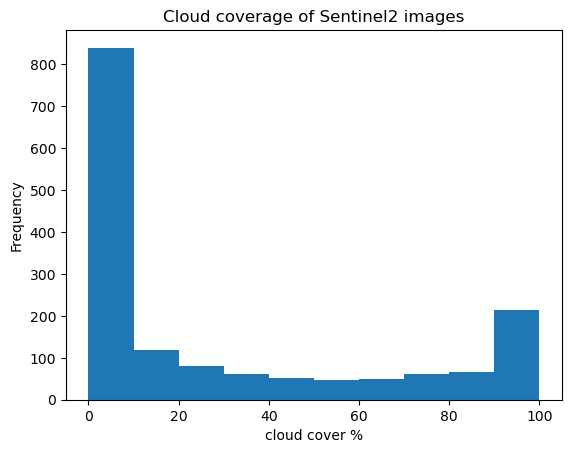

In [98]:
ax: plt.Axes = sentinel_products_metadata.loc[products]['cloudcoverpercentage'].plot(kind='hist', )
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [101]:
all_metars['timedelta'] = all_metars.apply(lambda row: row['datetime'].to_numpy() - sentinel_products_metadata.loc[row['product_id']]['beginposition'].to_numpy(), axis=1)

In [103]:
all_metars['datetime'].iloc[0]

Timestamp('2022-12-27 18:53:00+0000', tz='UTC')

In [104]:
sentinel_products_metadata.loc[all_metars['product_id']]['beginposition'].iloc[0]

Timestamp('2022-12-27 18:48:01.024000+0000', tz='UTC')

In [105]:
all_metars['timedelta'].iloc[0]

Timedelta('0 days 00:04:58.976000')

In [106]:
all_metars['timedelta'].iloc[0].total_seconds()

298.976

In [107]:
available_metars = all_metars[(all_metars['product_id'].isin(products)) \
                              & (all_metars['sky_conditions [M]'].map(lambda x: len(x) > 0))].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

7218 of 8211 METARs are available [87.9 %]


In [108]:
available_stations_in_products = []
for product in products:
    product_dir = os.path.join(features_dir, product)
    product_bands = os.listdir(product_dir)
    stations = set()
    for band in product_bands:
        band_dir = os.path.join(product_dir, band)
        stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
    for station in stations:
        available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [109]:
keys = list(available_stations_in_products.columns.values)
i1 = available_metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
available_metars = available_metars[i1.isin(i2)].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

6961 of 8211 METARs are available [84.8 %]


In [110]:
remaining_stations = available_metars['station'].drop_duplicates().to_numpy()
print(f'{len(remaining_stations)} stations remain')

121 stations remain


In [111]:
station_radius_of_influence = 8000.0 # meters

<class 'shapely.geometry.multipolygon.MultiPolygon'>


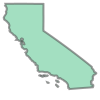

In [116]:
area_of_interest: MultiPolygon = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [117]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [118]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [119]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [120]:
remaining_stations_metadata = station_metadata.loc[remaining_stations]

In [121]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [122]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [123]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [124]:
intersections = intersections.sample(frac=1, random_state=1)

In [125]:
intersections.head()

,geometry,index_right
id,,
CCB,"POLYGON ((-117.60882 34.04626, -117.60882 34.17695, -117.76594 34.17695, -117.76594 34.04626, -117.60882 34.04626))",ONT
VNY,"POLYGON ((-118.41091 34.14473, -118.41091 34.27472, -118.56738 34.27472, -118.56738 34.14473, -118.41091 34.14473))",WHP
ONT,"POLYGON ((-117.52263 33.99063, -117.52263 34.12138, -117.67971 34.12138, -117.67971 33.99063, -117.52263 33.99063))",CNO
POC,"POLYGON ((-117.70327 34.02636, -117.70327 34.15695, -117.86024 34.15695, -117.86024 34.02636, -117.70327 34.02636))",CNO
CQT,"POLYGON ((-118.21305 33.95848, -118.21305 34.08860, -118.36932 34.08860, -118.36932 33.95848, -118.21305 33.95848))",HHR


In [126]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'9L2': ['EDW'], 'AJO': ['CNO'], 'BAB': ['MYV'], 'BUR': ['WHP', 'VNY'], 'CCB': ['POC', 'ONT'], 'CNO': ['ONT', 'POC', 'AJO'], 'CQT': ['SMO', 'HHR', 'LAX'], 'CRQ': ['OKB'], 'DVO': ['O69'], 'EDW': ['9L2'], 'HAF': ['SFO'], 'HHR': ['CQT', 'TOA', 'LAX', 'SMO'], 'HWD': ['OAK'], 'IPL': ['NJK'], 'L18': ['NFG'], 'LAX': ['CQT', 'SMO', 'HHR'], 'LPC': ['VBG'], 'MCC': ['MHR'], 'MCE': ['MER'], 'MER': ['MCE'], 'MHR': ['MCC'], 'MYF': ['SAN', 'NZY', 'NKX'], 'MYV': ['BAB'], 'NFG': ['NXF', 'L18', 'OKB'], 'NJK': ['IPL'], 'NKX': ['MYF', 'SAN'], 'NRS': ['NZY'], 'NUQ': ['SJC', 'PAO'], 'NXF': ['OKB', 'NFG'], 'NZY': ['SAN', 'MYF', 'NRS'], 'O69': ['DVO'], 'OAK': ['HWD', 'SFO'], 'OAR': ['SNS'], 'OKB': ['NXF', 'NFG', 'CRQ'], 'ONT': ['CCB', 'RAL', 'CNO'], 'PAO': ['NUQ', 'SQL'], 'PMD': ['WJF'], 'POC': ['CCB', 'CNO'], 'RAL': ['ONT'], 'SAN': ['NZY', 'MYF', 'NKX'], 'SFO': ['HAF', 'SQL', 'OAK'], 'SJC': ['NUQ'], 'SMO': ['CQT', 'HHR', 'LAX'], 'SNS': ['OAR'], 'SQL': ['SFO', 'PAO'], 'SUU': ['VCB'], 'TOA': ['HHR'], 'VBG': ['

In [127]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

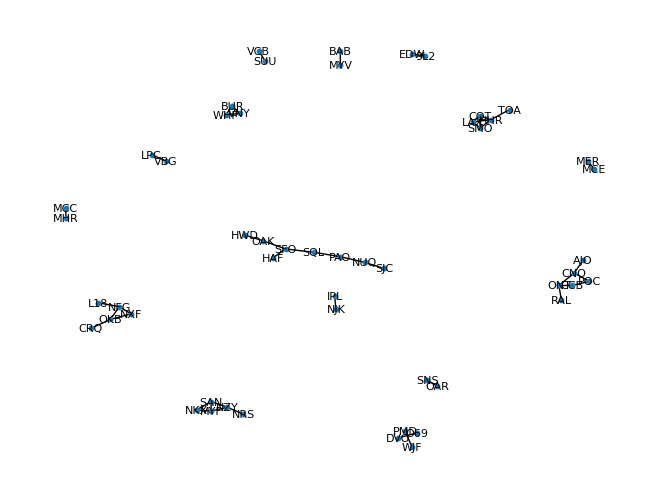

In [128]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [143]:
clusters = list(networkx.connected_components(graph))
print(clusters)
num_clusters = len(clusters)

[{'EDW', '9L2'}, {'CNO', 'RAL', 'POC', 'CCB', 'AJO', 'ONT'}, {'MYV', 'BAB'}, {'BUR', 'VNY', 'WHP'}, {'TOA', 'HHR', 'LAX', 'CQT', 'SMO'}, {'CRQ', 'OKB', 'NFG', 'NXF', 'L18'}, {'O69', 'DVO'}, {'PAO', 'HAF', 'OAK', 'HWD', 'NUQ', 'SJC', 'SQL', 'SFO'}, {'NJK', 'IPL'}, {'VBG', 'LPC'}, {'MCC', 'MHR'}, {'MER', 'MCE'}, {'NRS', 'SAN', 'NKX', 'NZY', 'MYF'}, {'SNS', 'OAR'}, {'PMD', 'WJF'}, {'VCB', 'SUU'}]


In [130]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'EDW': 0, '9L2': 0, 'CNO': 1, 'RAL': 1, 'POC': 1, 'CCB': 1, 'AJO': 1, 'ONT': 1, 'MYV': 2, 'BAB': 2, 'BUR': 3, 'VNY': 3, 'WHP': 3, 'TOA': 4, 'HHR': 4, 'LAX': 4, 'CQT': 4, 'SMO': 4, 'CRQ': 5, 'OKB': 5, 'NFG': 5, 'NXF': 5, 'L18': 5, 'O69': 6, 'DVO': 6, 'PAO': 7, 'HAF': 7, 'OAK': 7, 'HWD': 7, 'NUQ': 7, 'SJC': 7, 'SQL': 7, 'SFO': 7, 'NJK': 8, 'IPL': 8, 'VBG': 9, 'LPC': 9, 'MCC': 10, 'MHR': 10, 'MER': 11, 'MCE': 11, 'NRS': 12, 'SAN': 12, 'NKX': 12, 'NZY': 12, 'MYF': 12, 'SNS': 13, 'OAR': 13, 'PMD': 14, 'WJF': 14, 'VCB': 15, 'SUU': 15}


In [131]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['CCB', 'VNY', 'ONT', 'POC', 'CQT', 'EDW', 'POC', 'NZY', 'MYF', 'SAN', 'MYF', 'NXF', 'WHP', 'SFO', 'PMD', 'NZY', 'MCC', 'VBG', 'MYF', 'BUR', 'SAN', 'HWD', 'SMO', 'NFG', 'NXF', 'L18', 'SAN', 'HHR', 'RAL', 'BUR', 'OKB', 'NKX', 'OKB', 'SJC', 'CQT', 'NZY', 'ONT', 'HAF', 'CQT', 'LAX', 'PAO', 'WJF', 'CNO', 'OAR', 'AJO', 'NUQ', 'HHR', 'LPC', 'ONT', 'NFG', 'CCB', 'NKX', 'NFG', 'NJK', 'WHP', 'NUQ', 'VCB', 'SQL', 'MER', 'HHR', 'CNO', 'PAO', 'CNO', 'DVO', '9L2', 'BAB', 'TOA', 'SFO', 'CRQ', 'OKB', 'MHR', 'OAK', 'SFO', 'IPL', 'SQL', 'O69', 'LAX', 'SMO', 'MCE', 'OAK', 'VNY', 'LAX', 'SNS', 'HHR', 'SUU', 'SMO', 'MYV', 'NRS']


<Axes: title={'center': 'California'}>

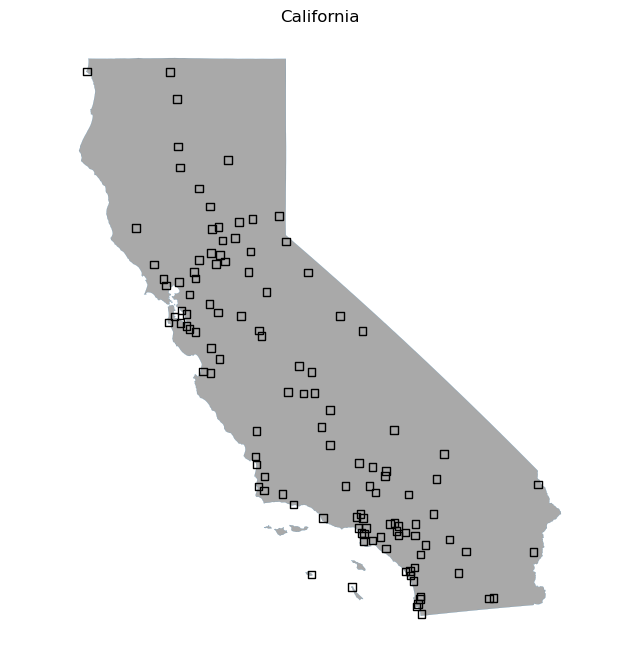

In [133]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

remaining_stations_metadata.plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'California'}>

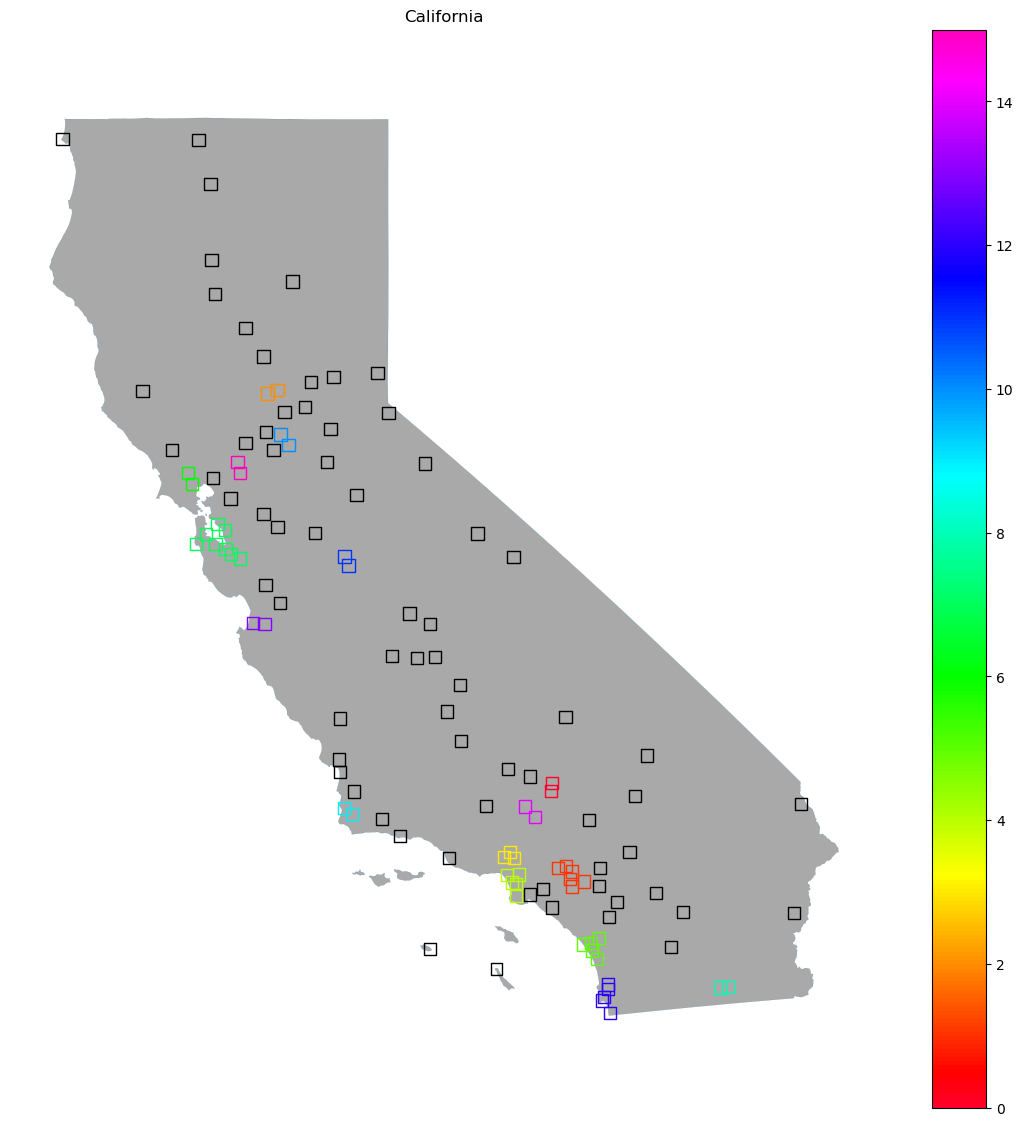

In [153]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

remaining_stations_metadata[remaining_stations_metadata['cluster'] == -1].plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)
remaining_stations_metadata[remaining_stations_metadata['cluster'] != -1].plot(
    column='cluster', ax=ax, facecolor='none', colormap='gist_rainbow', legend=True
)

In [154]:
cloud_covers = pd.DataFrame([available_metars['station'], available_metars['sky_conditions [M]']]).T
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

,station,sky_conditions [M],cloud cover
0,PRB,"[DataSkyConditions(cover='SCT', height=1127.7599639117, cloud=None), DataSkyConditions(cover='OVC', height=2133.5999317248, cloud=None)]","[SCT, OVC]"
1,PRB,"[DataSkyConditions(cover='FEW', height=182.8799941478, cloud=None), DataSkyConditions(cover='SCT', height=1676.3999463552, cloud=None), DataSkyConditions(cover='OVC', height=2133.5999317248, cloud=None)]","[FEW, SCT, OVC]"
2,SBP,"[DataSkyConditions(cover='SCT', height=274.3199912218, cloud=None), DataSkyConditions(cover='OVC', height=487.6799843942, cloud=None)]","[SCT, OVC]"
3,DLO,"[DataSkyConditions(cover='OVC', height=1402.0799551334, cloud=None)]",[OVC]
4,DLO,"[DataSkyConditions(cover='OVC', height=1341.1199570842, cloud=None)]",[OVC]
...,...,...,...
8206,L35,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
8207,L35,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
8208,L35,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
8209,PSP,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]


In [155]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['SCT', 'OVC', 'FEW', 'SCT', 'OVC', 'SCT', 'OVC', 'OVC', 'OVC', 'OVC', 'OVC', 'OVC', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'OVC', 'OVC', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'FEW', 'BKN', 'OVC', 'SCT', 'OVC', 'SCT', 'SCT', 'OVC', 'BKN', 'BKN', 'OVC', 'OVC', 'OVC', 'SCT', 'SCT', 'OVC', 'BKN', 'BKN', 'OVC', 'OVC', 'BKN', 'SCT', 'BKN', 'BKN', 'BKN', 'OVC', 'OVC', 'OVC', 'SCT', 'BKN', 'OVC', 'OVC', 'OVC', 'OVC', 'FEW', 'OVC', 'OVC', 'OVC', 'SCT', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'SCT', 'SCT', 'OVC', 'FEW', 'OVC', 'SCT', 'OVC', 'FEW', 'BKN', 'OVC', 'FEW', 'FEW', 'BKN', 'BKN', 'BKN', 'FEW', 'SCT', 'FEW', 'SCT', 'BKN', 'FEW', 'SCT', 'BKN', 'FEW', 'FEW', 'BKN', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'SCT', 'OVC', 'SCT', 'BKN', 'OVC', 'FEW', 'SCT', 'OVC', 'FEW', 'BKN', 'BKN', 'SCT', 'BKN', 'BKN', 'OVC', 'OVC', 'OVC', 'OVC', 'OVC', 'OVC'

<Axes: >

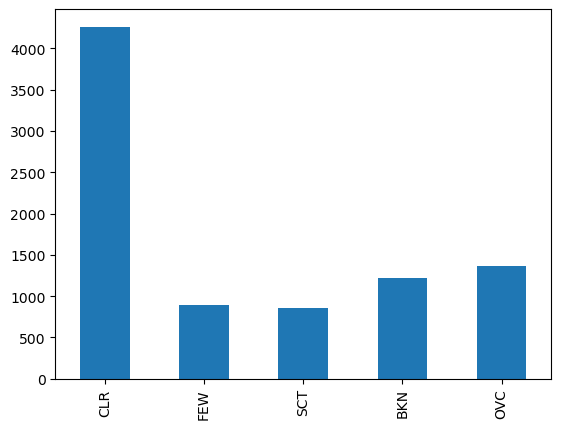

In [156]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

In [157]:
cloud_cover_strength = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [158]:
available_metars['max cloud cover'] = available_metars['sky_conditions [M]'].apply(get_max_cloud_cover)

In [159]:
cloud_covers['cloud cover max'] = cloud_covers['sky_conditions [M]'].map(get_max_cloud_cover)
cloud_covers['cloud cover max']

0       OVC
1       OVC
2       OVC
3       OVC
4       OVC
       ... 
8206    CLR
8207    CLR
8208    CLR
8209    CLR
8210    CLR
Name: cloud cover max, Length: 6961, dtype: object

In [160]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))

OVC    1370
BKN     526
FEW     377
SCT     384
CLR    4262
VV       42
dtype: int64

<Axes: title={'center': 'Maximum cloud coverage by weather stations'}>

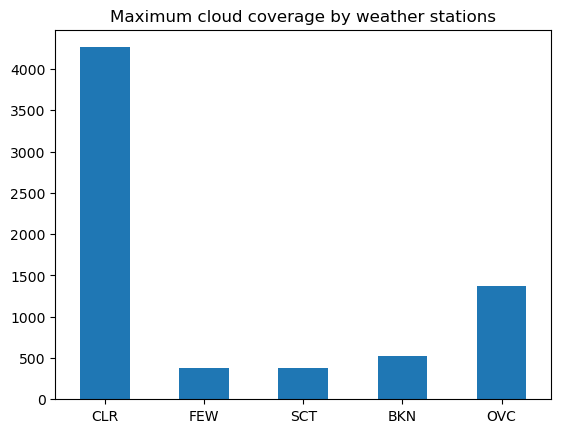

In [161]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].plot(kind='bar', title='Maximum cloud coverage by weather stations', rot=0)

In [162]:
cloud_covers_max_per_station = {}
for station, data in cloud_covers.groupby('station'):
    cloud_covers_max_per_station[station] = pd.Series(dict(Counter(data['cloud cover max'])))
cloud_covers_max_per_station = pd.DataFrame(cloud_covers_max_per_station)
cloud_covers_max_per_station

,9L2,AJO,APC,AUN,BAB,BAN,BFL,BIH,BLH,BLU,...,TSP,TVL,UKI,VBG,VCB,VCV,VIS,VNY,WHP,WJF
BKN,NaN,1.0,6.0,2.0,4.0,1.0,2,1.0,NaN,NaN,...,6.0,6.0,4.0,6.0,2.0,1.0,1.0,NaN,1.0,2.0
CLR,25.0,26.0,17.0,76.0,22.0,19.0,50,27.0,24.0,24.0,...,83.0,78.0,19.0,9.0,21.0,90.0,16.0,22.0,23.0,32.0
FEW,2.0,NaN,1.0,3.0,NaN,NaN,1,1.0,1.0,1.0,...,1.0,4.0,2.0,5.0,NaN,NaN,NaN,1.0,NaN,1.0
OVC,2.0,8.0,11.0,26.0,28.0,5.0,14,3.0,NaN,11.0,...,9.0,65.0,13.0,9.0,17.0,2.0,15.0,10.0,3.0,3.0
SCT,NaN,1.0,2.0,1.0,3.0,1.0,3,1.0,2.0,1.0,...,NaN,NaN,2.0,6.0,1.0,NaN,NaN,2.0,1.0,NaN
VV,NaN,NaN,NaN,NaN,1.0,1.0,2,NaN,NaN,8.0,...,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


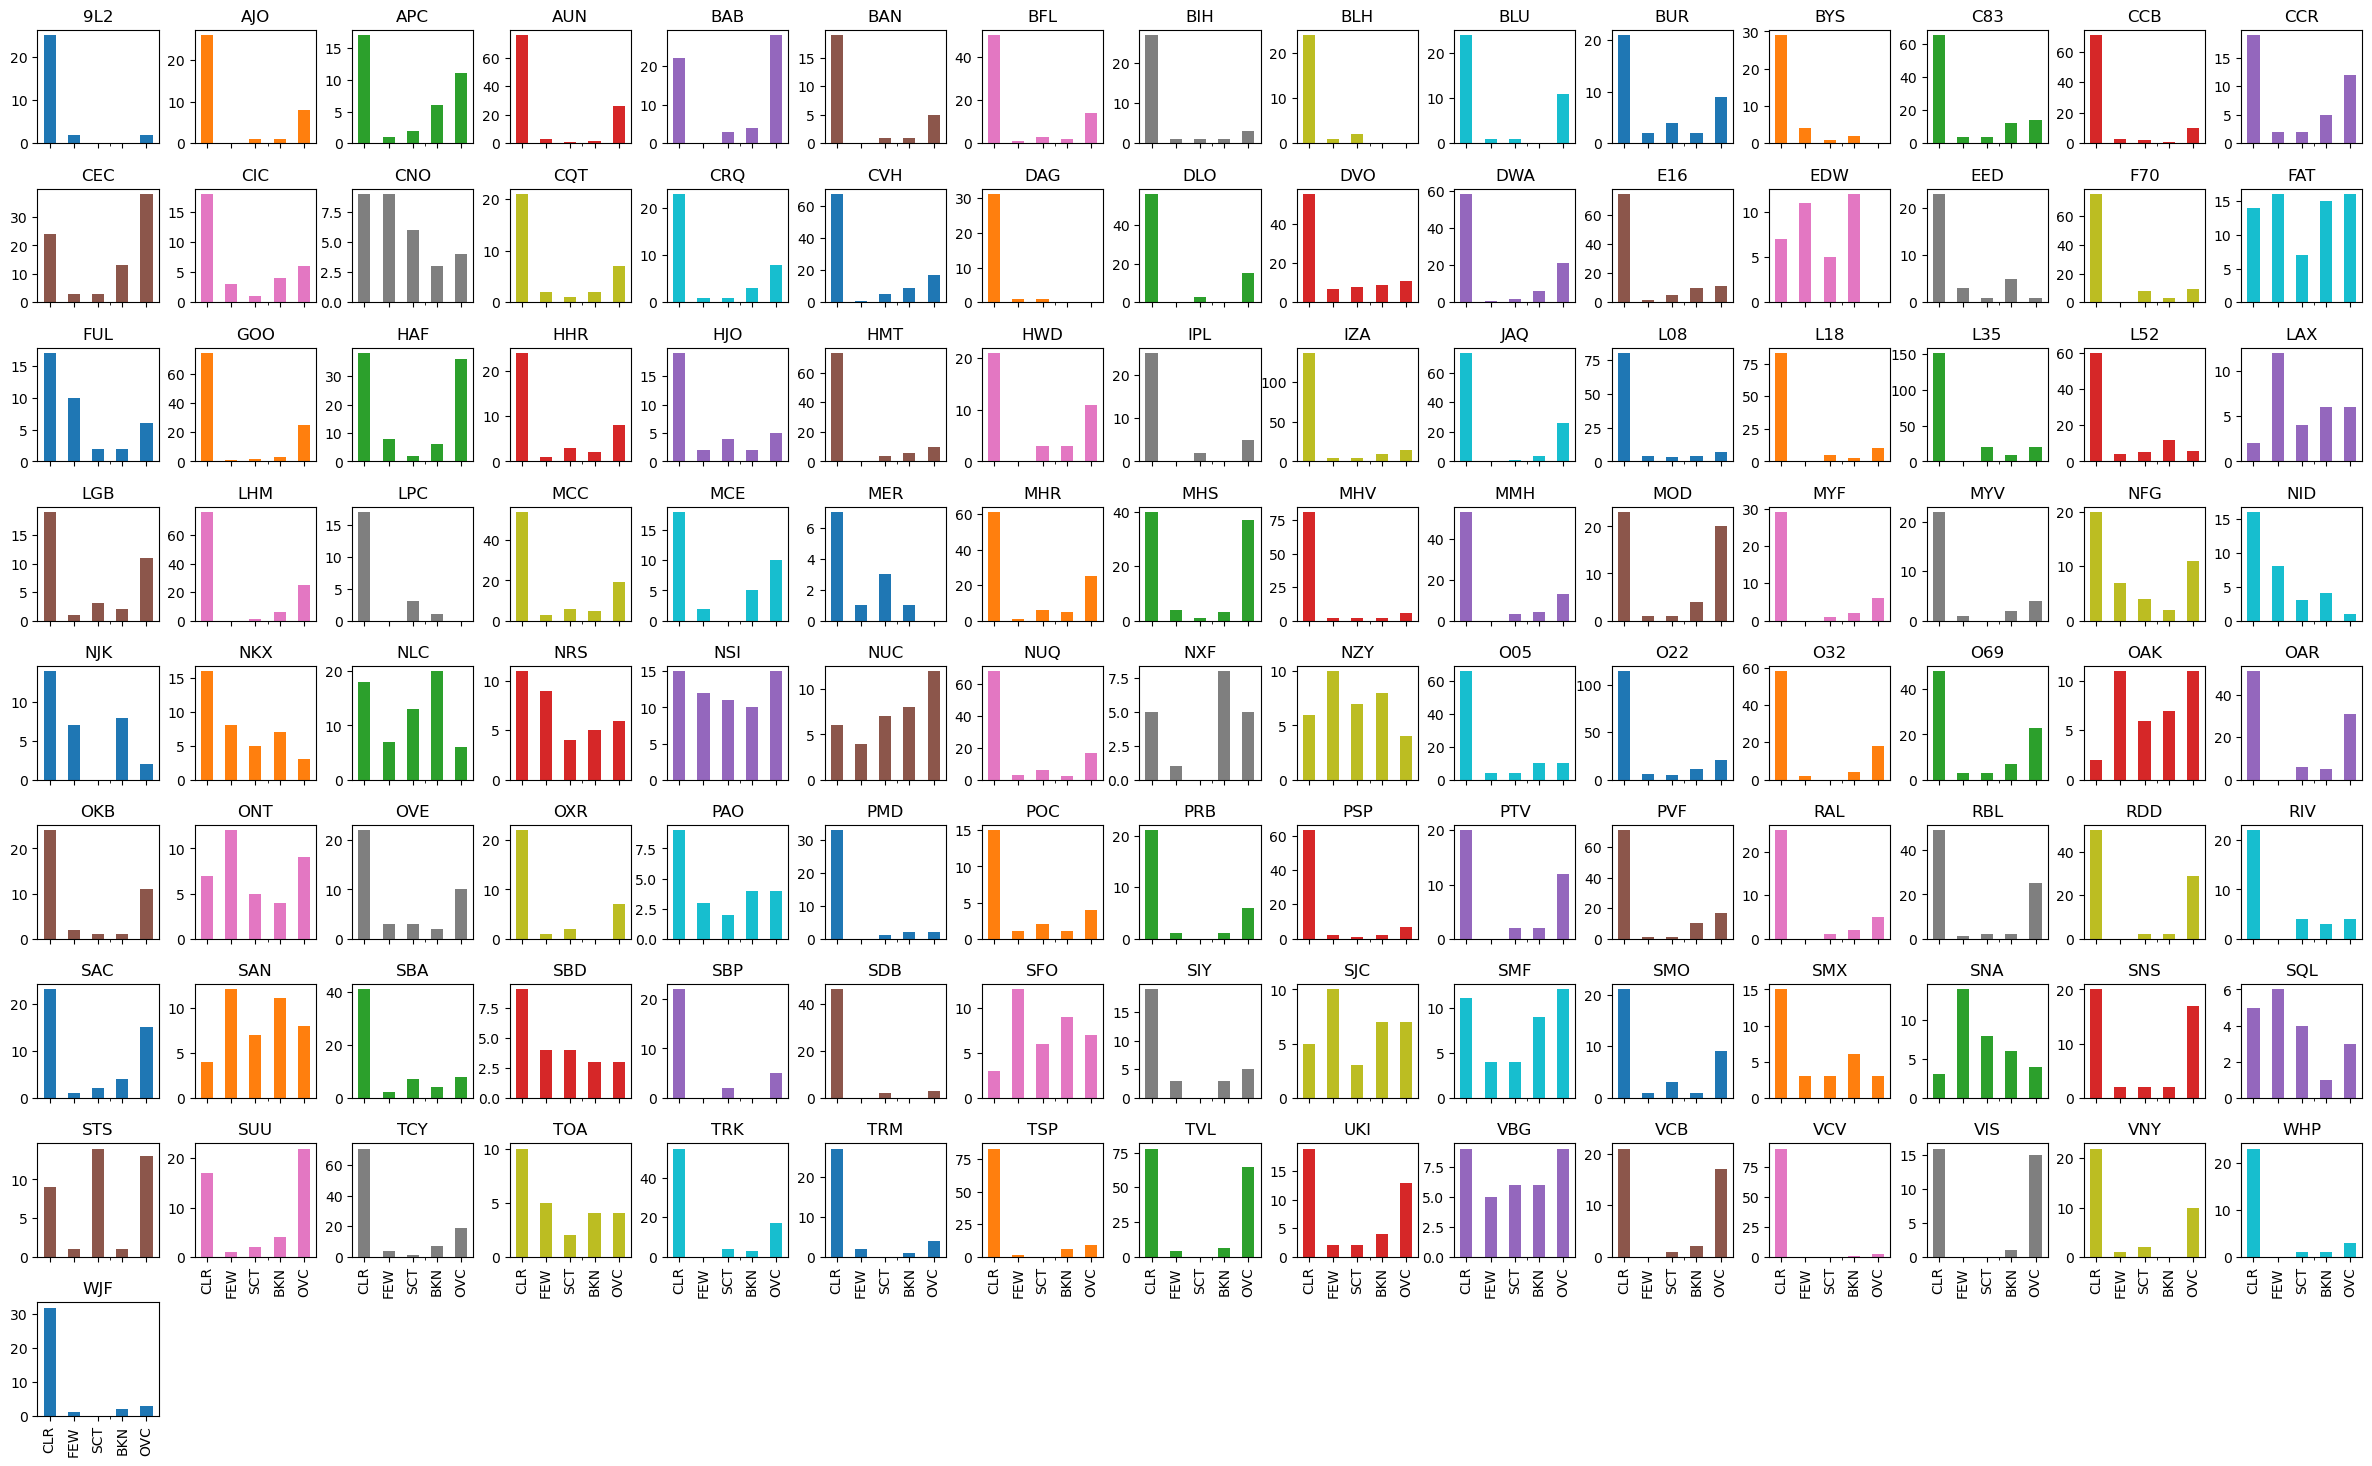

In [164]:
from numpy import ceil

plot_share_x = True
plot_layout_scale = 2.0
plot_layout_columns = 15
plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
    layout=(plot_layout_rows, plot_layout_columns),
    figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
if not plot_share_x:
    plt.subplots_adjust(wspace=0.3, hspace=1.0)
else:
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [165]:
metars_no_multiple_station_observations = available_metars.drop_duplicates(subset=['station', 'product_id'])
print(f'{metars_no_multiple_station_observations.shape[0]} of {available_metars.shape[0]}'
      ' METARs are left when removing additional observations of the same station per product'
      f' [{float(metars_no_multiple_station_observations.shape[0]) / float(available_metars.shape[0]) * 100.0:.1f} %]')
metar_station_counts = metars_no_multiple_station_observations.groupby(['station'])['product_id'].count().sort_values()

4203 of 6961 METARs are left when removing additional observations of the same station per product [60.4 %]


<Axes: xlabel='station'>

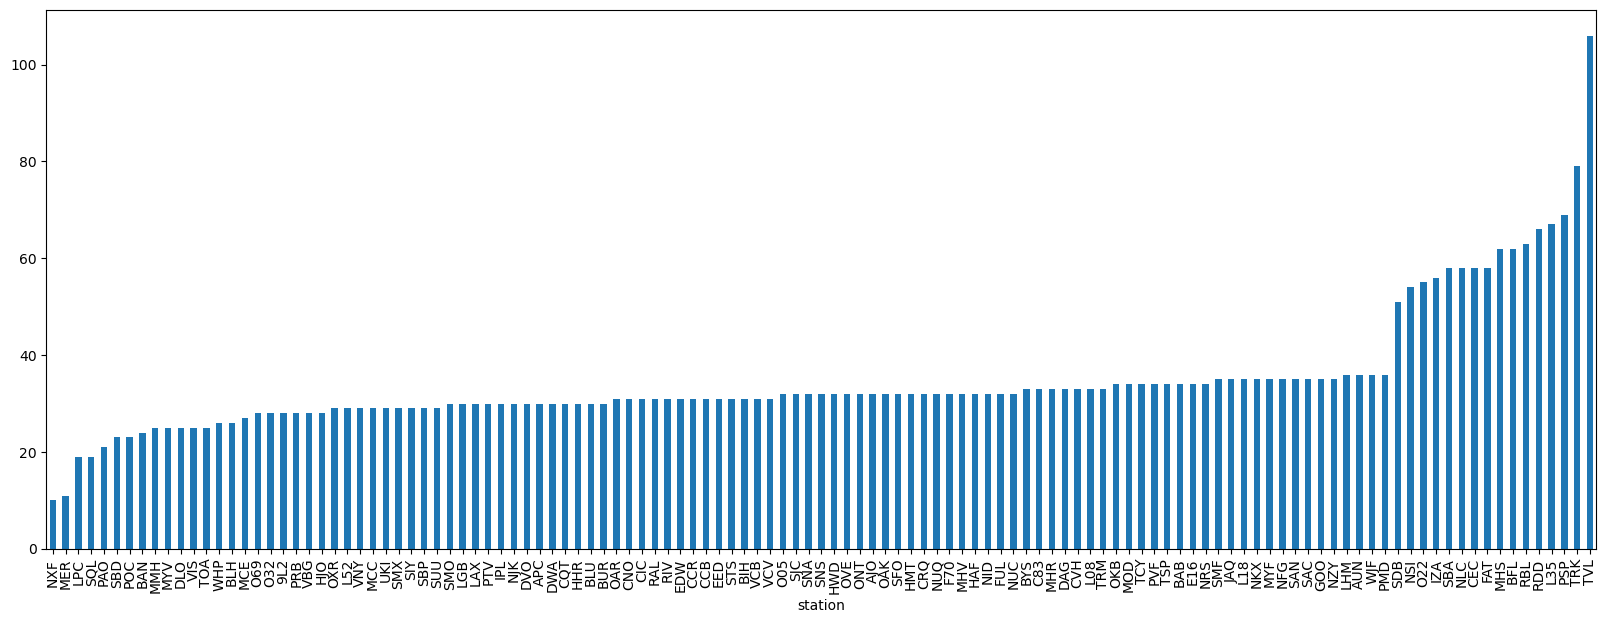

In [167]:
metar_station_counts.plot(kind='bar', figsize=(20,7))

<Axes: ylabel='Frequency'>

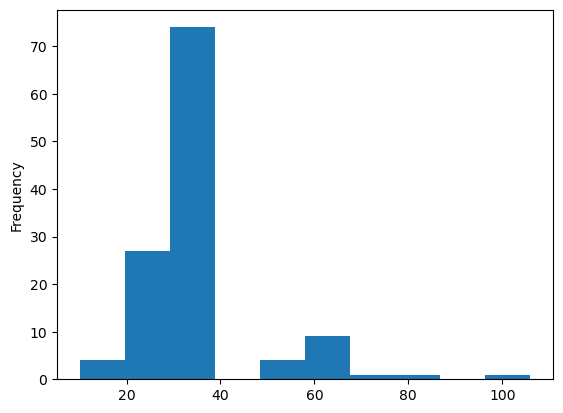

In [168]:
metar_station_counts.plot(kind='hist')

In [169]:
station_quantity = available_metars.groupby('station')['product_id'].count()
station_quantity

station
9L2     29
AJO     36
APC     37
AUN    108
BAB     58
      ... 
VCV     93
VIS     32
VNY     35
WHP     28
WJF     38
Name: product_id, Length: 121, dtype: int64

In [170]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [171]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'BAN', 'L52', 'NSI', 'L35', 'MOD', 'BIH', 'CEC', 'DLO', 'PTV', 'E16', 'MHV', 'PRB', 'RBL', 'SBP', 'SNA', 'O22', 'HJO', 'TVL', 'IZA', 'SBA', 'O32', 'RDD', 'JAQ', 'C83', 'F70', 'CVH', 'L08', 'SMF', 'NUC', 'SMX', 'LHM', 'APC', 'OVE', 'SAC', 'DWA', 'BYS', 'FUL', 'NLC', 'UKI', 'DAG', 'SBD', 'PVF', 'RIV', 'PSP', 'EED', 'MHS', 'GOO', 'TRM', 'AUN', 'BLH', 'SDB', 'TCY', 'HMT', 'TSP', 'MMH', 'STS', 'FAT', 'CCR', 'CIC', 'NID', 'VIS', 'TRK', 'BFL', 'LGB', 'BLU', 'O05', 'SIY', 'OXR', 'VCV'}


In [172]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'EDW', '9L2'}, quantity=64), DatasetUnit(stations={'CNO', 'RAL', 'POC', 'CCB', 'AJO', 'ONT'}, quantity=247), DatasetUnit(stations={'MYV', 'BAB'}, quantity=87), DatasetUnit(stations={'BUR', 'VNY', 'WHP'}, quantity=101), DatasetUnit(stations={'TOA', 'HHR', 'LAX', 'CQT', 'SMO'}, quantity=161), DatasetUnit(stations={'CRQ', 'OKB', 'NFG', 'NXF', 'L18'}, quantity=242), DatasetUnit(stations={'O69', 'DVO'}, quantity=174), DatasetUnit(stations={'PAO', 'HAF', 'OAK', 'HWD', 'NUQ', 'SJC', 'SQL', 'SFO'}, quantity=372), DatasetUnit(stations={'NJK', 'IPL'}, quantity=63), DatasetUnit(stations={'VBG', 'LPC'}, quantity=56), DatasetUnit(stations={'MCC', 'MHR'}, quantity=185), DatasetUnit(stations={'MER', 'MCE'}, quantity=48), DatasetUnit(stations={'NRS', 'SAN', 'NKX', 'NZY', 'MYF'}, quantity=189), DatasetUnit(stations={'SNS', 'OAR'}, quantity=136), DatasetUnit(stations={'PMD', 'WJF'}, quantity=76), DatasetUnit(stations={'VCB', 'SUU'}, quantity=92), DatasetUnit(stations={'BAN'}, quan

Text(0.5, 0, 'Average number of METARS per satellite image')

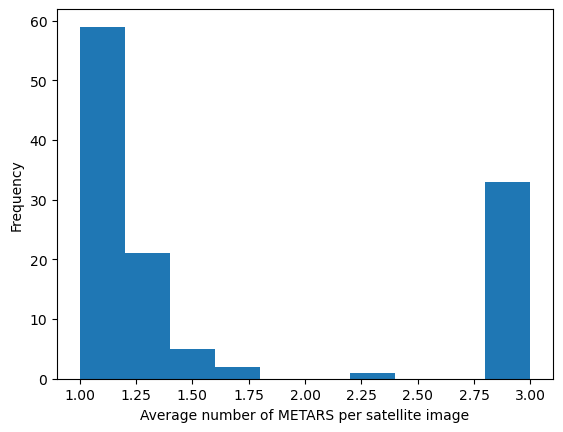

In [173]:
ax: plt.Axes = available_metars.groupby(['station', 'product_id'])['datetime'].count().groupby('station').mean().plot(kind='hist')
ax.set_xlabel('Average number of METARS per satellite image')

Text(0.5, 0, 'quantity of METARs')

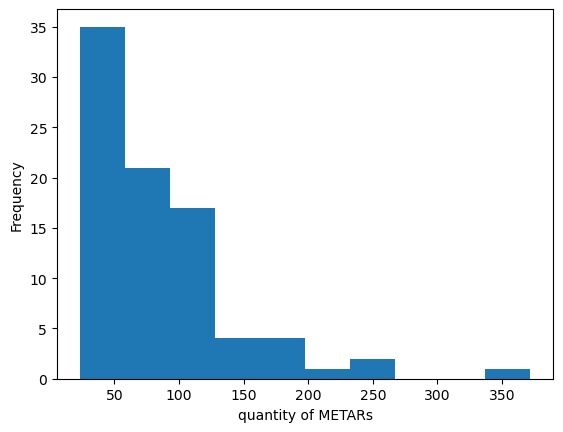

In [174]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot(kind='hist', legend=False)
ax.set_xlabel('quantity of METARs')

In [175]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

In total, 6961 units of data are to be distributed for the dataset


In [176]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [177]:
dataset_split = DatasetSplit(0.80, 0.10, 0.10)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.1f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.1f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.1f} %]')

DatasetSplit target:
Training:	5567	[80.0 %]
Validation:	697	[10.0 %]
Test:		697	[10.0 %]


In [178]:
dataset_units.sort(reverse=True)
dataset_units

[DatasetUnit(stations={'PAO', 'HAF', 'OAK', 'HWD', 'NUQ', 'SJC', 'SQL', 'SFO'}, quantity=372),
 DatasetUnit(stations={'CNO', 'RAL', 'POC', 'CCB', 'AJO', 'ONT'}, quantity=247),
 DatasetUnit(stations={'CRQ', 'OKB', 'NFG', 'NXF', 'L18'}, quantity=242),
 DatasetUnit(stations={'L35'}, quantity=200),
 DatasetUnit(stations={'NRS', 'SAN', 'NKX', 'NZY', 'MYF'}, quantity=189),
 DatasetUnit(stations={'MCC', 'MHR'}, quantity=185),
 DatasetUnit(stations={'O69', 'DVO'}, quantity=174),
 DatasetUnit(stations={'IZA'}, quantity=168),
 DatasetUnit(stations={'TOA', 'HHR', 'LAX', 'CQT', 'SMO'}, quantity=161),
 DatasetUnit(stations={'O22'}, quantity=158),
 DatasetUnit(stations={'TVL'}, quantity=158),
 DatasetUnit(stations={'SNS', 'OAR'}, quantity=136),
 DatasetUnit(stations={'LHM'}, quantity=108),
 DatasetUnit(stations={'AUN'}, quantity=108),
 DatasetUnit(stations={'GOO'}, quantity=105),
 DatasetUnit(stations={'JAQ'}, quantity=104),
 DatasetUnit(stations={'E16'}, quantity=102),
 DatasetUnit(stations={'TCY'}

In [179]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])

In [180]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [181]:
training, validation, test = greedy_partition(dataset_split, total_quantity, dataset_units)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.1f} %]')

DatasetSplit:
Training:	5574	[80.1 %]
Validation:	681	[9.8 %]
Test:		706	[10.1 %]


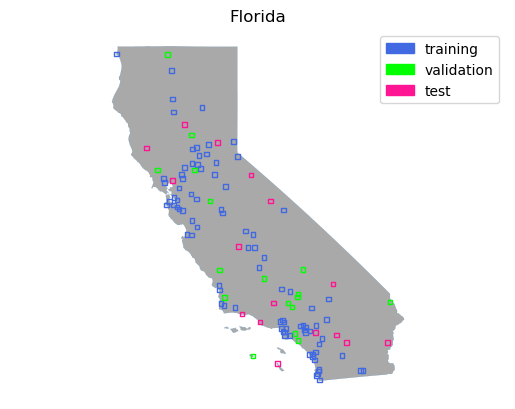

In [182]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Florida')
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

color_training = 'royalblue'
color_validation = 'lime'
color_test = 'deeppink'

patch_training = mpatches.Patch(color=color_training, label='training')
patch_validation = mpatches.Patch(color=color_validation, label='validation')
patch_test = mpatches.Patch(color=color_test, label='test')

remaining_stations_metadata.loc[list(training.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_training, legend=True
)
remaining_stations_metadata.loc[list(validation.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_validation, legend=True
)
remaining_stations_metadata.loc[list(test.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_test, legend=True
)

ax.legend(handles=[patch_training, patch_validation, patch_test])

In [183]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [184]:
print(training.get_stations())

{'CNO', 'RAL', 'PAO', 'HAF', 'BIH', 'CQT', 'SJC', 'DLO', 'PTV', 'E16', 'MHV', 'SMO', 'TOA', 'HJO', 'TVL', 'MER', 'CRQ', 'HWD', 'JAQ', 'RDD', 'VCB', 'F70', 'SNS', 'L08', 'SMF', 'LHM', 'DWA', 'HHR', 'POC', 'LAX', 'DAG', 'PVF', 'MHS', 'WHP', 'AUN', 'BUR', 'TCY', 'TSP', 'HMT', 'FAT', 'VNY', 'CCR', 'OKB', 'OAR', 'VIS', 'LGB', 'O05', 'VCV', 'L52', 'CCB', 'L35', 'NFG', 'CEC', 'NXF', 'RBL', 'AJO', 'SBP', 'O22', 'IZA', 'MCC', 'MHR', 'BAB', 'NUQ', 'O32', 'C83', 'CVH', 'SQL', 'IPL', 'LPC', 'DVO', 'ONT', 'SAN', 'NKX', 'SBD', 'O69', 'MYV', 'SFO', 'L18', 'GOO', 'MYF', 'SUU', 'NRS', 'MCE', 'NJK', 'OAK', 'NZY', 'VBG', 'TRK'}


In [185]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]

In [186]:
def get_features_path(station:str, product_id:str, band:str):
    return os.path.join(features_dir, product_id, band, f'{station}.jp2')

def get_dataset_local_dir(station:str, product_id:str):
    return os.path.join(station, product_id)

def get_dataset_path(target_dir:str, station:str, product_id:str, band:str):
    return os.path.join(target_dir, get_dataset_local_dir(station, product_id), f'{band}.jp2')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[str, str]]:
    data_subset = available_metars[(available_metars['station'].isin(dataset.get_stations()))\
                                   & (available_metars['max cloud cover'].isin(cloud_covers_order))]
    result = data_subset.apply(
        lambda x: [(get_features_path(x.station, x.product_id, band),
                    get_dataset_path(target_dir, x.station, x.product_id, band)) for band in bands], axis=1)
    return [x for sublist in result for x in sublist]

In [187]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [188]:
for path_from, path_to in dataset_file_mappings:
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        shutil.copyfile(path_from, path_to)

In [206]:
def get_newest_label(data:pd.DataFrame) -> str:
    return data.loc[data['timedelta [minutes]'].abs().idxmin()]

In [251]:
def create_dataset_labels(dataset:Dataset):
    labels = available_metars[available_metars['station'].isin(dataset.get_stations())\
                              & (available_metars['max cloud cover'].isin(cloud_covers_order))].copy()
    labels['timedelta [minutes]'] = labels['timedelta'].map(lambda x: x.total_seconds() / 60.0)
    labels = labels[['max cloud cover', 'temperature [C]', 'timedelta [minutes]', 'station', 'product_id']]
    return labels.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))

In [252]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

<Axes: title={'center': 'Test'}, ylabel='Frequency'>

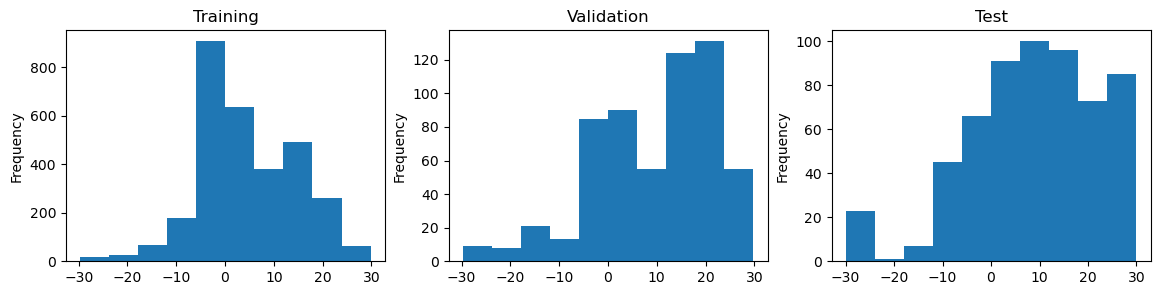

In [253]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[0], title='Training')
validation_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[1], title='Validation')
test_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[2], title='Test')

In [254]:
def print_time_dist(data:pd.DataFrame, name:str):
    series = data['timedelta [minutes]']
    print(f'{name}\tmean: {series.mean():.1f} minutes,\tvariance: {series.var():.1f}')

print_time_dist(training_labels, 'Training')
print_time_dist(validation_labels, 'Validation')
print_time_dist(test_labels, 'Test\t')

Training	mean: 4.6 minutes,	variance: 101.0
Validation	mean: 9.8 minutes,	variance: 158.1
Test		mean: 8.7 minutes,	variance: 176.5


<Axes: title={'center': 'Test'}>

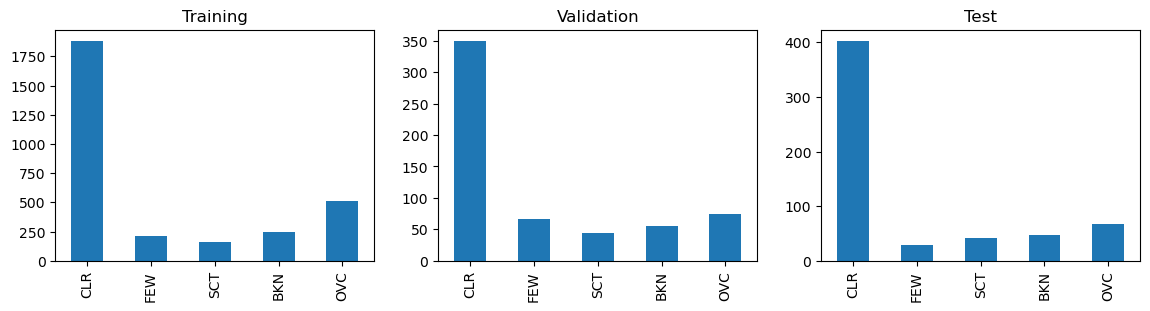

In [261]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
pd.Series(dict(Counter(training_labels['max cloud cover'])))\
    .loc[cloud_covers_order].plot(kind='bar', ax=axs[0], title='Training')
pd.Series(dict(Counter(validation_labels['max cloud cover'])))\
    .loc[cloud_covers_order].plot(kind='bar', ax=axs[1], title='Validation')
pd.Series(dict(Counter(test_labels['max cloud cover'])))\
    .loc[cloud_covers_order].plot(kind='bar', ax=axs[2], title='Test')

In [255]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [195]:
bands_metadata = pd.DataFrame([bands, band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [M]']
bands_metadata

,band,resolution [M]
0,B1,60
1,B2,10
2,B3,10
3,B4,10
4,B5,20
5,B6,20
6,B7,20
7,B8,10
8,B8A,20
9,B9,60


In [196]:
bands_metadata.to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=False)